In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Eigenfaces - Survey and Implementation from Scratch
## Author: Boyan Kaloyanov

### Abstract
This paper describes a complete implementation of the eigenfaces algorithm for face recognition. The process is followed from  choice of dataset, through principal component analysis, to recognition rate testing, with each step explained mathematically and executed in Python code. Some recommendations are given in the end regarding potential improvements and adjustments for real-world applications.

### Introduction
Eigenfaces is an approach to solving the problem of human face recognition. It uses a collection of images of training faces from which a set of eigenvectors is extracted using principal component analysis (hence the name eigenfaces). Specifically, the eigenfaces are the components of a distribution of faces, or equivalently, the eigenvectors of the covariance matrix of the set of face images, where an image with **N** pixels is considered a point (or vector) in **N**-dimensional space [1]. Any subsequent images are broken down to a linear combination of these eigenfaces. This data is then stored and compared with new images for the purpose of recognition.

### Preparing the Data
The training dataset used in this implementation is AT&T's Database of Faces [6]. To work efficiently, eigenfaces requires that the images are grayscale, centered and have little variation in lighting. The dataset contains images of forty different people's faces, with ten pictures of each person. The images of thirty of those people were used as the training set (300 images in total), with the other ten left for the test set (100 images). Another requirement is that the images have the same size - in this case that is 92x112 pixels. For the purpose of eigenfaces, each image needs to be reshaped into a vector of length 92x112 = 10304 pixels:

In [3]:
def vectorize_image(path):
    img = mpimg.imread(path)
    return img.ravel()
    
IMG_PATH = 'images/s{0}/{1}.pgm'
TOTAL_PERSON_COUNT = 40
TRAIN_PERSON_COUNT = 30
IMG_PER_PERSON = 10
IMG_HEIGHT, IMG_WIDTH = mpimg.imread(IMG_PATH.format(1, 1)).shape

vectorized_images = []
for person_no in range(1, TRAIN_PERSON_COUNT + 1):
    for image_no in range(1, IMG_PER_PERSON + 1):
        vectorized_images.append(vectorize_image(IMG_PATH.format(person_no, image_no)))

gamma = np.array(vectorized_images)

Next, the "average face" needs to be subtracted from each sample. The average, or mean, is calculated using the formula: $$\psi = \frac{1}{M}\sum_{i=1}^{M}\Gamma_{i}$$
where **M** is the number of face images and $\{\Gamma_{1},\Gamma_{2}...,\Gamma_{M}\}$ is the set of the images in vector form.

In [4]:
psi = np.mean(gamma, axis = 0)

The average is then subtracted from each image: $\Phi_{i} = \Gamma_{i} - \psi$, to create a new set of vectors $A = \{\Phi_{1},\Phi_{2}...,\Phi_{M}\}$

In [5]:
A = (gamma - psi).T

### Eigenvectors and Eigenvalues
In linear algebra, an eigenvector or characteristic vector of a linear transformation is a non-zero vector that only changes by a scalar factor when that linear transformation is applied to it [2]. This condition can be expressed using the formula $Av = {\lambda}v$, where $A$ is the transformation matrix $\{\Phi_{1},\Phi_{2}...,\Phi_{M}\}$ and $\lambda$ is the scaling factor, also called the eigenvalue. If $Av = {\lambda}v$, then $v$ is an eigenvector of $A$.

The eigenfaces are the eigenvectors of the covariance matrix, $C$, of $A$, which can be determined using the formula [3]: $$C = \frac{1}{M}\sum_{i=1}^{M}\Phi_{i}\Phi_{i}^{T} = AA^{T}$$
However, finding $AA^{T}$ can be computationally very expensive. It is an $N^2xN^2$ ($N$ = length of the image vectors) matrix, where $N = 10304$ for the chosen set of images. Luckily, it turns out that the matrix $A^{T}A$ can be used instead. This is an $MxM$ matrix, which in this particular case equates to a size of $300x300$:
$$A^{T}Av_{i} = \mu_{i}v_{i}$$
$$AA^{T}Av_{i} = \mu_{i}Av_{i}$$
$$CAv_{i} = \mu_{i}Av_{i}$$
$$Cu_{i} = \mu_{i}u_{i},$$
where $u_{i} = Av_{i}$. Thus, the eigenvectors and eigenvalues of $AA^{T}$ and $A^{T}A$ are related as $u_{i} = Av_{i}$. 
It is worth mentioning that $AA^{T}$ has a total of $N^2$ eigenvectors, while $A^{T}A$ only has $M$. The $M$ eigenvalues of $A^{T}A$ (along with the respective eigenvectors) correspond to the $M$ *largest* eigenvalues of $AA^{T}$ [3].

In [6]:
eigvals, eigvects = np.linalg.eig(A.T @ A)

c_eigvects = A @ eigvects

# normalize eigenvectors of covariance matrix so they have a length of 1
c_eigvects = np.array([eigvect / math.sqrt(np.dot(eigvect, eigvect))
                                   for eigvect in c_eigvects])

### Choosing K << M Eigenfaces
The next step is to take the $K$ eigenvectors with the largest eigenvalue ($K<M$). The goal is to reduce the dimensionality (and therefore the amount of data needed to be stored for each image) while still preserving the majority of the information of the image. This can be expressed with the following criterion [3]: $$\frac{\sum_{i=1}^{K}\lambda_{i}}{\sum_{i=1}^{M}\lambda_{i}} > Threshold$$
As explained by [4], 15% of eigenfaces for optimal recognition rate. The threshold value has been set at 0.985 in order for the calculated $K$ value to come close to this estimation. In the case of this implementation, 15% out of 300 = 45 eigenfaces.

In [7]:
k = 2
k_threshold = 0.85
fraction_preserved = 0

sum_m = eigvals.sum()
while fraction_preserved < k_threshold:
    sum_k = eigvals[0:k].sum()
    
    fraction_preserved = sum_k / sum_m
    k += 1

eigenfaces = c_eigvects[:, 0:k].T

percentage = round(fraction_preserved, 4) * 100
print(f"Number of eigenfaces required to preserve {percentage}% of eigenvalues: {k}")

Number of eigenfaces required to preserve 85.13% of eigenvalues: 59


The calculated value for $K$ of 59 is close to the recommended 15%, albeit on the upper side. The higher number of eigenfaces results in a slightly improved recognition rate at the cost of computing and storage time. However, considering the relatively small training sample and total number of eigenfaces, the difference is negligible. <br><br>
The process of splitting the training images into orthogonal (uncorrelated) components, i.e. the eigenfaces, and choosing a subset of them to respresent the images is also called Principal Component Analysis (PCA). Eigenfaces is a concrete example of PCA.

### Visualizing the Eigenfaces
Matrix multiplication in more than three dimensions is usually near-impossible to visualize. Intuitive understanding of what is happening behind the scenes can be achieved, but the individual steps make no visual sense. One of the nicer features of eigenfaces is that they can be observed (and make for an intriguing sight):

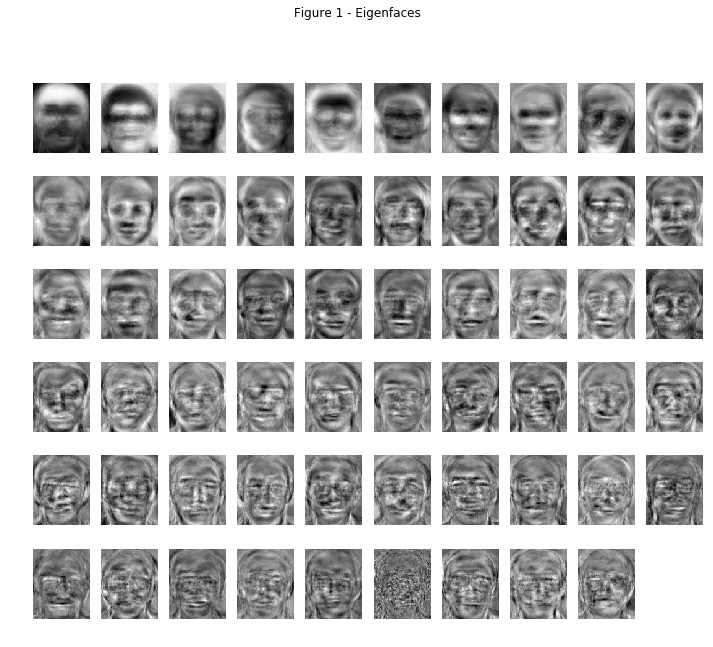

In [8]:
nrows = 6
ncols = math.ceil(k / nrows)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, figsize = (12, 10))
fig.suptitle('Figure 1 - Eigenfaces')

row = 0
col = 0
for eigenface in eigenfaces:
    axes[row, col].axis('off')
    imgplot = axes[row, col].imshow(eigenface\
                                        .reshape((IMG_HEIGHT, IMG_WIDTH)), cmap = 'gray')
    
    if col % k == ncols - 1:
        col = 0
        row += 1
    else:
        col += 1
        
# in case nrows is not an exact multiple of the number of eigenfaces,
# remove the axes for better presentation
while col != 0:
    axes[row, col].axis('off')
    
    if col == ncols - 1:
        col = 0
    else:
        col += 1

As can be seen, the eigenfaces resemble images of real faces. The essence of the algorithm is to find the "building blocks" of the training set. It is then natural that they look similar to actual faces.
### Representing Images As a Combination of Eigenfaces
Any image can now be represented as a linear combination of the eigenfaces. Since the eigenface matrix is $NxK$ dimensional, while a vector representing the eigenface weights of an image is $Kx1$ dimensional, there is no single solution to the equation $Ax = b$ (where $x$ is the weight vector being computed and $A$ is the eigenface matrix). In linear algebra terms, this is due to the dimension of the rowspace of the eigenface matrix being higher than the dimension of its column space ($N > K$). To overcome this, an estimation is used called the *Least Squares Approximation*. As summarized by [5]: "The method of least squares is a standard approach in regression analysis to approximate the solution of overdetermined systems, i.e., sets of equations in which there are more equations than unknowns. "Least squares" means that the overall solution minimizes the sum of the squares of the residuals made in the results of every single equation".
<br><br>Figures 2 and 3 show an example of an original image and its recreated version found using the eigenface weights computed by the least squares method. The recreated image resembles the original, but is far from a perfect replica. With a higher value for $K$, the two figures would look more and more identical. However, it must be noted that a higher $K$-value would mean more of the original eigenfaces would need to be stored for each image, with each having a smaller eigenvalue than the last. Therefore, increases in percentage of information retained would require a progressively larger number of eigenfaces and, as a consequence, data stored in the database. This would obviously not be a huge concern in this small-scale implementation, but is an issue when considering real-world applications. As mentioned earlier, a good compromise is usually achieved with roughly 15% of eigenfaces.

In [9]:
def calculate_eigenface_weights(eigenfaces, face_vector):
    return np.linalg.lstsq(a = eigenfaces, b = face_vector, rcond=None)[0]

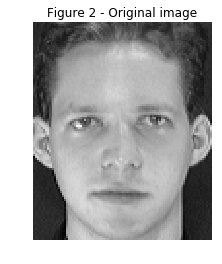

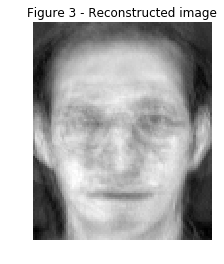

In [10]:
weight_vector = calculate_eigenface_weights(eigenfaces.T, A.T[0])

# show original image
original_img = mpimg.imread(IMG_PATH.format(1, 1))
plt.imshow(original_img, cmap = 'gray')
plt.title('Figure 2 - Original image')
plt.axis('off')
plt.show()

# show reconstructed image
img = eigenfaces.T @ weight_vector + psi
img.shape = (IMG_HEIGHT, IMG_WIDTH)
plt.imshow(img, cmap = 'gray')
plt.title('Figure 3 - Reconstructed image')
plt.axis('off')
plt.show()

### Face Recognition
Five out of the ten pictures of each person from the test set will be weighted using the eigenfaces calculated during the training phase, and the weights stored to create a face database. The remaining images will be used to test face recognition.

In [11]:
# creating the 'database'
database = dict()
DB_IMG_PERSON = 5

for person_no in range(TRAIN_PERSON_COUNT + 1, TOTAL_PERSON_COUNT + 1):
    for image_no in range(1, DB_IMG_PERSON + 1):
        # the mean image must be subtracted first
        normalized_img = vectorize_image(IMG_PATH.format(person_no, image_no)) - psi
        
        weight_vector = calculate_eigenface_weights(eigenfaces.T, normalized_img)
        
        if not person_no in database:
            database[person_no] = []
        database[person_no].append(weight_vector)

Unless an image identical to one in the database is used, an exact match of all eigenface weights would never be found. Therefore, to determine if a new image is showing a face already stored, an error $e_{r}$ is calculated (difference between eigenface weights) and the minimum is taken [3]: $$e_{r} = min_{l}||\Omega - \Omega^{l}||$$ 
The distance $||\Omega - \Omega^{l}||$ is  the Euclidean distance between the weight vectors of the database and test faces.
<br><br>
For the algorithm to function correctly, a certain error threshold $T_{r}$ needs to be established. If $e_{r} > T{r}$, the face is considered to be new to the database. If there was no threshold, the algorithm would always succeed in finding a match. According to  Gupta et al.[4], a threshold  value of 0.8 times the largest of the minimum Euclidean distances between two training images allows for a good recognition rate. However, in this particular case it was found not to be optimal and in fact a value of 1.1 times the largest minimum distance gave best results. It should be noted that this value only works for the particular choice of the number of eigenfaces and data. With more data, the threshold might have to get closer to the approximation recommended by Gupta et al.

In [12]:
def find_minimum_distance(image, database):
    min_distance = float('inf')
    person_min_dist = ''
    for person, weights in database.items():
        distance = min([np.linalg.norm(image - weight) for weight in weights])
        
        if(distance < min_distance):
            min_distance = distance
            person_min_dist = person
            
    return person_min_dist, min_distance

In [13]:
db_weights = [w for weight in list(database.values()) for w in weight]
min_distances = []

for i in range(len(db_weights) - 1):
    # calculate distances between each pair of images in the 'database'
    distances = [np.linalg.norm(db_weights[i] - db_weights[j])
                         for j in range(i + 1, len(db_weights))]
    
    min_distance = min(distances)
    min_distances.append(min_distance)
    
threshold = 1.1 * max(min_distances)

The remaining images can now be used to test face recognition:

In [14]:
test_images = []
recognized_correct = 0
recognized_incorrect = 0
unrecognized = 0
for person_no in range(TRAIN_PERSON_COUNT + 1, TOTAL_PERSON_COUNT + 1):
    for image_no in range(DB_IMG_PERSON + 1, IMG_PER_PERSON + 1):
        normalized_img = vectorize_image(IMG_PATH.format(person_no, image_no)) - psi
        weight_vector = calculate_eigenface_weights(eigenfaces.T, normalized_img)
        
        person, min_distance = find_minimum_distance(weight_vector, database)

        if(min_distance < threshold):
            if(person == person_no):
                recognized_correct += 1
            else:
                recognized_incorrect += 1
        else:
            unrecognized += 1

print('Correctly recognized: {}'.format(recognized_correct))
print('Incorrectly recognized: {}'.format(recognized_incorrect))
print('Unrecognized: {}'.format(unrecognized))
print('Face recognition accuracy: {}%'.format(recognized_correct * 100 / (recognized_correct + recognized_incorrect + unrecognized)))

Correctly recognized: 47
Incorrectly recognized: 3
Unrecognized: 0
Face recognition accuracy: 94.0%


### Conclusion
This notebook describes the process of the eigenfaces algorithm for face recognition. While overall a success with a relatively high recognition rate, the implementation outlined here is incomplete when it comes to practical use. For example, no preprocessing is done to the images. The database only contains pictures of faces on a dark background, with very little variation in lighting. In practice, most images would not have been taken in such ideal conditions - some work would have to be done to recognize the part of an image containing the face, cropping it, changing the background and adjusting the lighting. It is also possible to manipulate the angle at which the face is shown to get a frontal image. All these preprocessing steps would be required in a real-world application. However, the sole purpose of this implementation is to show the basic steps in setting up eigenfaces and how the algorithm works.

### References
[1] Turk M. and Zhang S.(2008) Eigenfaces. Scholarpedia, [http://www.scholarpedia.org/article/Eigenfaces](http://www.scholarpedia.org/article/Eigenfaces) <br>
[2] (May 2018). Eigenvalues and Eigenvectors. Wikipedia, [https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) <br>
[3] Turk M. and Pentland A. (1991) Eigenfaces. [http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf](http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf) <br>
[4] Gupta et al. (Apr 2010) A New Optimized Approach to Face Recognition Using Eigenfaces. Global Journal of 
Computer Science and Technology, [https://pdfs.semanticscholar.org/1e1c/fcd1da24ec87a4b59b248e826c14a82c66f8.pdf](https://pdfs.semanticscholar.org/1e1c/fcd1da24ec87a4b59b248e826c14a82c66f8.pdf) <br>
[5] (May 2018) Least squares. Wikipedia, [https://en.wikipedia.org/wiki/Least_squares](https://en.wikipedia.org/wiki/Least_squares) <br>
[6] AT&T. Database of Faces. [http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)